In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [2]:
# Load dataset
data = pd.read_csv('kurla_cleaned.csv', parse_dates=['date'], index_col='date')

In [3]:
# Select columns for prediction
cols = ['PM2.5', 'PM10', 'NO', 'NO2', 'SO2', 'CO']
data = data[cols].copy()


In [4]:
# Normalize data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [5]:
# Create input-output pairs for LSTM model
look_back = 24
X, y = [], []
for i in range(len(data_scaled) - look_back):
    X.append(data_scaled[i:i+look_back, :])
    y.append(data_scaled[i+look_back, 0])
X, y = np.array(X), np.array(y)

In [6]:
# Split data into training and test sets
train_size = int(len(X) * 0.9)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [7]:
# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [8]:
# Define LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [16]:
import keras
print(keras.__version__)

2.12.0


In [9]:
# Train LSTM model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=2)


Epoch 1/10
494/494 - 6s - loss: 0.0037 - val_loss: 2.4108e-04 - 6s/epoch - 12ms/step
Epoch 2/10
494/494 - 4s - loss: 4.8482e-05 - val_loss: 1.6102e-04 - 4s/epoch - 7ms/step
Epoch 3/10
494/494 - 3s - loss: 2.8638e-05 - val_loss: 7.2552e-05 - 3s/epoch - 7ms/step
Epoch 4/10
494/494 - 4s - loss: 2.3597e-05 - val_loss: 8.1477e-05 - 4s/epoch - 7ms/step
Epoch 5/10
494/494 - 4s - loss: 1.8919e-05 - val_loss: 2.3365e-04 - 4s/epoch - 8ms/step
Epoch 6/10
494/494 - 4s - loss: 1.6865e-05 - val_loss: 1.7458e-04 - 4s/epoch - 8ms/step
Epoch 7/10
494/494 - 4s - loss: 1.6789e-05 - val_loss: 2.1036e-04 - 4s/epoch - 8ms/step
Epoch 8/10
494/494 - 4s - loss: 1.1486e-05 - val_loss: 2.9069e-05 - 4s/epoch - 8ms/step
Epoch 9/10
494/494 - 4s - loss: 1.7559e-05 - val_loss: 3.6132e-04 - 4s/epoch - 8ms/step
Epoch 10/10
494/494 - 4s - loss: 1.2525e-05 - val_loss: 6.2647e-05 - 4s/epoch - 8ms/step


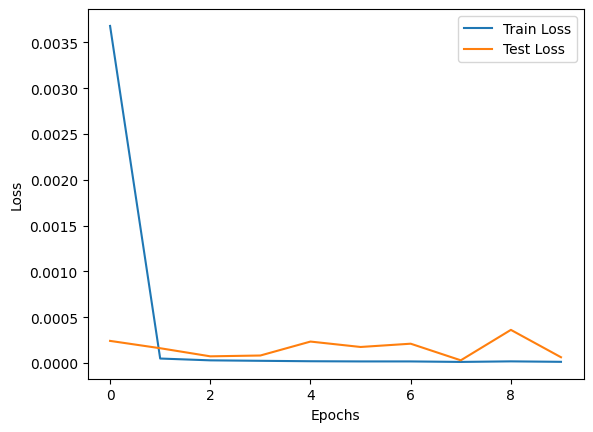

In [12]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
prediction_dates = pd.date_range(start='2023-03-01', end='2023-03-31', freq='H')
X_pred = data_scaled[-look_back:, :, :]
X_pred = np.reshape(X_pred, (1, look_back, X_pred.shape[1]))
pollutant_pred = []
for i in range(len(prediction_dates)):
    pred = model.predict(X_pred)
    pollutant_pred.append(pred[0, 0])
    X_pred = np.append(X_pred[:, 1:, :], np.expand_dims(pred, axis=1), axis=1)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed